In [1]:
from keys import *
import json
import pandas as pd
import numpy as np
from json.decoder import JSONDecodeError
from pandas.io.json import json_normalize
import os
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics as st

# Supporting functions Collapsed in next cell

In [24]:
def read_csvs(directory, df_combined):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            csv_path    = os.path.join(directory, filename)
            df_file     = pd.read_csv(csv_path)
            df_combined = pd.concat([df_combined, df_file])
        else:
            continue
    return df_combined

def expand_multi_level_cols(df_combined):
    types       = ["creator", "location", "profile", "category" ]

    n           = len(df_combined)
    df_out      = pd.DataFrame()

    for type_i in types:
        df          = df_combined[type_i]
        if type_i == 'photo':
            df_loop = pd.DataFrame(columns=photo_keys)

        elif type_i == 'creator':
            df_loop = pd.DataFrame(columns=creator_keys)

        elif type_i == 'location':
            df_loop = pd.DataFrame(columns=location_keys)

        elif type_i == 'profile':
            df_loop = pd.DataFrame(columns=profile_keys)

        elif type_i == 'category':
            df_loop = pd.DataFrame(columns=category_keys)

        for i in range(0, n):
            try:
                item       = df[i]
                dic        = json.loads(item)
                x          = pd.json_normalize(dic)
                df_loop    = df_loop.append(x, ignore_index=True)
            except:
                continue
        df_out = pd.concat([df_out, df_loop], axis=1)
        return df_out
    
def get_stats(feature):
    mu = round(st.mean(feature), 0)
    sigma = round(st.stdev(feature), 0)
    lower = mu - 3*sigma
    upper = mu + 3*sigma
    vc = feature.value_counts()
    if lower < 0:
        lower = 0
    range_str = f"Mean = {mu} , 6 sigma range = {lower} : {upper}"
    return mu, sigma, vc, range_str


def load_data(df_type, fname):
    # This is first file from june_2021 to start dataframe (removed from june 21 folder)
    df           = pd.read_csv(fname)
    df_expand    = expand_multi_level_cols(df)
    df_final     = df.drop(columns=["creator", "location", "profile", "category"])
    df_final     = pd.concat([df_final, df_expand], axis=1)
    idx_1        = df_final['state'] == 'failed'
    idx_2        = df_final['state'] == 'successful'
    df_final     = df_final[idx_1 | idx_2]
    df_final     = wrangle(df_final)
    pkl_file     = 'df_' + df_type + '.pkl'
    df_final.to_pickle(pkl_file)
    return df_final

def wrangle(df):
    df_out = df.copy()
    
    # Replace empty goal rows with nan
    df_out['goal'] = df_out['goal'].replace('', np.nan)
    
    # remove rows without goal:
    df_out = df_out[ df_out['goal'] != np.nan ]
    
    # filter df to projects goal to raise $500 to $250,000
    df_out = df_out[(df_out['goal'] >= 500) & (df_out['goal']<= 250000 )]
    
    df_out['deadline']        = pd.to_datetime(df_out['deadline'], unit='s')
    df_out['launched_at']     = pd.to_datetime(df_out['launched_at'], unit='s')
    df_out['campaign_length'] = df_out['deadline'] - df_out['launched_at']
    df_out['pledge_pct_goal'] = df_out['converted_pledged_amount'].divide(df_out['goal'])
    
    return df_out

def eda(df):
    
    # Plot 2d Hist of Pledged and Goal
    y, x = df['converted_pledged_amount'], df['goal']

    x_mean, x_std, o, p = get_stats(x)
    y_mean, y_std, o, p = get_stats(y)

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.hist2d(x, y, bins=100, range=[[0, 50000], [0, 50000]])
    axs.set_title('Hist Map Pledged vs. Goal')
    axs.set_xlabel('Goal')
    axs.set_ylabel('Pledged')
    plt.tight_layout()
    
    # Plot 2d Hist of Pledged and % of Goal Funded
    y, x = df['pledge_pct_goal'], df['goal']

    x_mean, x_std, o, p = get_stats(x)
    y_mean, y_std, o, p = get_stats(y)

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.hist2d(x, y, bins=100, range=[[0, 50000], [0, 2]])
    axs.set_title('Hist Map Goal vs. % Goal Funded, n_bins =100')
    axs.set_xlabel('Goal')
    axs.set_ylabel('% of Goal Funded')
    plt.tight_layout()
    
    # Plot 2d Hist of Pledged and % of Goal Funded
    y, x = df['pledge_pct_goal'], df['goal']

    x_mean, x_std, o, p = get_stats(x)
    y_mean, y_std, o, p = get_stats(y)

    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.hist2d(x, y, bins=50, range=[[0, 50000], [0, 2]])
    axs.set_title('Hist Map Goal vs. % Goal Funded, n_bins = 50')
    axs.set_xlabel('Goal')
    axs.set_ylabel('% of Goal Funded')
    plt.tight_layout()
    
    
    # Plot Hists of Pledged and Goal in $
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))
    y, x = df_test['converted_pledged_amount'], df_test['goal']

    x_mean, x_std, o, p = get_stats(x)
    y_mean, y_std, o, p = get_stats(y)

    axs[0].hist(x, bins=300, range=[0, 50000])
    axs[0].hist(y, bins=300, range=[0, 50000])
    # axs[0].axis([0, 250, 0, 1000 ])
    axs[0].set_title('Hist n_bins=300, Range: 0 - $50K')
    axs[0].set_xlabel('Goal')
    axs[0].set_ylabel('Count')

    axs[1].hist(y, bins=200, range=[100, 50000])
    axs[1].hist(x, bins=200, range=[100, 50000])
    axs[1].set_title('Hist n_bins=200, Range: $100 - $50K')
    axs[1].set_xlabel('Pledged')
    axs[1].set_ylabel('Count')
    plt.tight_layout()

    # Plot Goal / Pledged Distributiuons
    
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))
    features = ['goal','converted_pledged_amount']
    for feat in features:
        mu, sigma, v, range_str = get_stats(df[feat])
        print(feat+ " " + range_str)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        axs[0].plot(x, stats.norm.pdf(x, mu, sigma))
    axs[0].axis([0, 100000, 0, 1.6*10**-5])
    axs[0].set_title('Goal and Pledged Distributions')
    axs[0].set_ylabel('Probability')
    axs[0].set_xlabel('$')
    axs[0].legend(features)

    feat = 'pledge_pct_goal'
    mu, sigma, v, range_str = get_stats(df[feat])
    print(feat+ " " + range_str)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    axs[1].plot(x, stats.norm.pdf(x, mu, sigma))
    axs[1].axis([0, 20, 0, .07])
    axs[1].set_ylabel('Probability')
    axs[1].set_xlabel('% of Goal Funded')
    axs[1].set_title('Distribution: % of Goal Funded')
    axs[1].legend([feat])
    
    
    # Plot Scatter of goal vs. pledge and goal vs. pct funded
    
    fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))

    x, y = df['goal']/1000, df['converted_pledged_amount'] /1000
    zeros, ones = np.zeros(len(x)), np.ones(len(x))
    xx = x.sort_values()

    axs[0].scatter(y = y, x=x)
    axs[0].set_title("Goal vs. Pledged Amount ($K)")
    axs[0].set_xlabel('Goal ($K)')
    axs[0].set_ylabel("Pledged ($K)")
    axs[0].fill_between(xx, 0, xx, color='red', alpha=0.2)
    axs[0].fill_between(xx, 100, xx, color='green', alpha=0.2)
    axs[0].axis([0, 100, 0, 100])


    x, y = df['goal']/1000, df['pledge_pct_goal']
    axs[1].scatter(y=y, x= x)
    axs[1].fill_between(xx, 1, 0, color='red', alpha=0.2)
    axs[1].fill_between(xx, 10, 1, color='green', alpha=0.2)
    axs[1].set_title("Goal vs. % of Goal Funded")
    axs[1].set_xlabel('Goal ($K)')
    axs[1].set_ylabel("% Goal Funded")
    axs[1].axis([0, 100, 0, 10])
    
def plot_train_test_target(df_train, df_test):
    y_train_count = df_train['state'].value_counts()
    y_test_count  = df_test['state'].value_counts()
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    x = np.array([1,2])

    ax.bar(x, y_train_count, width=.5)
    ax.bar(x+.5, y_test_count, width=.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Successful', 'Failed'], rotation = 45)
    ax.set_ylabel('Count')
    ax.set_title("Training & Test Target Class Count")

In [3]:
# just one df takes ~few mins to process, removing rest for now
# df_combined  = read_csvs(d_folder_1, df_combined)
# df_combined  = read_csvs(d_folder_2, df_combined)

train_fname = './data/Kickstarter.csv'
test_fname  = './data/Kickstarter001.csv'
df_train    = load_data('train', train_fname)
df_test     = load_data('test', test_fname) 

In [4]:
df_train.shape, df_test.shape

((2986, 51), (3012, 51))

In [5]:
df_train.head()

,backers_count,blurb,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,...,is_superbacker,avatar,urls,avatar.thumb,avatar.small,avatar.medium,urls.web.user,urls.api.user,campaign_length,pledge_pct_goal
1,146,Help us finish a feature film about two strang...,10120,US,the United States,1327602001,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/005/910/605/a...,https://ksr-ugc.imgix.net/assets/005/910/605/a...,https://ksr-ugc.imgix.net/assets/005/910/605/a...,https://www.kickstarter.com/profile/1939666693,https://api.kickstarter.com/v1/users/193966669...,49 days 10:58:34,1.012000
2,41,Considered playfully mischievous and outlaws i...,3785,US,the United States,1447448673,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/007/087/961/6...,https://ksr-ugc.imgix.net/assets/007/087/961/6...,https://ksr-ugc.imgix.net/assets/007/087/961/6...,https://www.kickstarter.com/profile/roguecodan...,https://api.kickstarter.com/v1/users/101884698...,30 days 00:00:00,1.261667
3,466,A fantastical love story about two New Yorkers...,21634,US,the United States,1359739327,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/005/987/612/0...,https://ksr-ugc.imgix.net/assets/005/987/612/0...,https://ksr-ugc.imgix.net/assets/005/987/612/0...,https://www.kickstarter.com/profile/488675737,https://api.kickstarter.com/v1/users/488675737...,29 days 23:00:00,1.081700
4,70,A story about a girl named Jane who is learnin...,3081,US,the United States,1330026300,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/005/925/157/3...,https://ksr-ugc.imgix.net/assets/005/925/157/3...,https://ksr-ugc.imgix.net/assets/005/925/157/3...,https://www.kickstarter.com/profile/shakyballoon,https://api.kickstarter.com/v1/users/220105304...,29 days 15:38:13,1.027000
5,166,A short film portraying the despair of a resea...,6115,GB,the United Kingdom,1408536568,GBP,£,False,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/008/591/512/2...,https://ksr-ugc.imgix.net/assets/008/591/512/2...,https://ksr-ugc.imgix.net/assets/008/591/512/2...,https://www.kickstarter.com/profile/1567687816,https://api.kickstarter.com/v1/users/156768781...,30 days 01:00:00,2.038333


In [6]:
df_test.head()

,backers_count,blurb,converted_pledged_amount,country,country_displayable_name,created_at,currency,currency_symbol,currency_trailing_code,current_currency,...,is_superbacker,avatar,urls,avatar.thumb,avatar.small,avatar.medium,urls.web.user,urls.api.user,campaign_length,pledge_pct_goal
0,44,“Tripping the Light Fantastic” cDc's new evoca...,2154,US,the United States,1375716180,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/006/736/731/d...,https://ksr-ugc.imgix.net/assets/006/736/731/d...,https://ksr-ugc.imgix.net/assets/006/736/731/d...,https://www.kickstarter.com/profile/concordance,https://api.kickstarter.com/v1/users/649433872...,30 days 00:00:00,1.077000
1,102,A suspenseful adaptation of Edgar Allan Poe’s ...,6131,US,the United States,1374106946,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/007/786/258/6...,https://ksr-ugc.imgix.net/assets/007/786/258/6...,https://ksr-ugc.imgix.net/assets/007/786/258/6...,https://www.kickstarter.com/profile/1943040097,https://api.kickstarter.com/v1/users/194304009...,33 days 00:14:07,1.021833
2,17,"Hi, I am looking to create these lovely Fan A...",467,US,the United States,1518674951,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/020/242/497/d...,https://ksr-ugc.imgix.net/assets/020/242/497/d...,https://ksr-ugc.imgix.net/assets/020/242/497/d...,https://www.kickstarter.com/profile/1266698815,https://api.kickstarter.com/v1/users/126669881...,29 days 23:00:00,0.518889
3,35,A sci-fi short about the relationship between ...,1261,DE,Germany,1605711443,EUR,€,False,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/027/910/766/7...,https://ksr-ugc.imgix.net/assets/027/910/766/7...,https://ksr-ugc.imgix.net/assets/027/910/766/7...,https://www.kickstarter.com/profile/guardianai...,https://api.kickstarter.com/v1/users/209606685...,24 days 21:33:04,1.261000
4,101,Kinetic Makeover is a new dance work by Milka ...,3600,US,the United States,1362009545,USD,$,True,USD,...,None,NaN,NaN,https://ksr-ugc.imgix.net/assets/006/064/734/c...,https://ksr-ugc.imgix.net/assets/006/064/734/c...,https://ksr-ugc.imgix.net/assets/006/064/734/c...,https://www.kickstarter.com/profile/23511873,https://api.kickstarter.com/v1/users/23511873?...,28 days 08:58:50,1.200000


In [7]:
df_train.to_excel('df_train.xlsx')
df_test.to_excel('df_test.xlsx')

In [8]:
df_train.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'country_displayable_name', 'created_at', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'name',
       'permissions', 'photo', 'pledged', 'slug', 'source_url', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls',
       'usd_exchange_rate', 'usd_pledged', 'usd_type', 'id', 'name', 'slug',
       'is_registered', 'is_email_verified', 'chosen_currency',
       'is_superbacker', 'avatar', 'urls', 'avatar.thumb', 'avatar.small',
       'avatar.medium', 'urls.web.user', 'urls.api.user', 'campaign_length',
       'pledge_pct_goal'],
      dtype='object')

In [9]:
df_train.describe()

,backers_count,converted_pledged_amount,created_at,fx_rate,goal,id,pledged,state_changed_at,static_usd_rate,usd_exchange_rate,usd_pledged,campaign_length,pledge_pct_goal
count,2986.000000,2.986000e+03,2.986000e+03,2986.000000,2986.000000,2.986000e+03,2.986000e+03,2.986000e+03,2986.000000,2986.000000,2.986000e+03,2986,2986.000000
mean,251.333557,2.321144e+04,1.462994e+09,1.015933,12424.128637,1.073281e+09,2.354764e+04,1.469696e+09,1.016046,1.015824,2.318778e+04,31 days 08:29:23.262893503,2.007789
std,1650.811663,1.923184e+05,9.698903e+07,0.204322,26360.233990,6.250572e+08,1.722938e+05,9.735864e+07,0.212263,0.212425,1.922753e+05,11 days 18:04:34.608831211,5.634798
min,0.000000,0.000000e+00,1.252853e+09,0.049112,500.000000,1.132300e+05,0.000000e+00,1.257597e+09,0.041017,0.040899,0.000000e+00,1 days 00:00:00,0.000000
25%,20.000000,1.210000e+03,1.392803e+09,1.000000,2000.000000,5.383573e+08,1.196250e+03,1.400898e+09,1.000000,1.000000,1.210000e+03,26 days 06:34:58.500000,1.000000
50%,51.000000,3.960000e+03,1.451499e+09,1.000000,5000.000000,1.080353e+09,4.008500e+03,1.457544e+09,1.000000,1.000000,3.973500e+03,30 days 00:00:00,1.067954
75%,123.000000,1.030050e+04,1.542982e+09,1.000000,10000.000000,1.606345e+09,1.044614e+04,1.552259e+09,1.000000,1.000000,1.030575e+04,32 days 21:16:57,1.374125
max,58561.000000,8.324792e+06,1.621672e+09,1.399194,250000.000000,2.147380e+09,6.840648e+06,1.623888e+09,1.714466,1.715913,8.332854e+06,90 days 23:00:00,143.630000


In [10]:
df_test.describe()

,backers_count,converted_pledged_amount,created_at,friends,fx_rate,goal,id,is_backing,is_starred,permissions,pledged,state_changed_at,static_usd_rate,usd_exchange_rate,usd_pledged,campaign_length,pledge_pct_goal
count,3012.000000,3.012000e+03,3.012000e+03,0.0,3012.000000,3012.000000,3.012000e+03,0.0,0.0,0.0,3.012000e+03,3.012000e+03,3012.000000,3012.000000,3.012000e+03,3012,3012.000000
mean,209.942895,1.950811e+04,1.466301e+09,NaN,1.016105,12599.093363,1.060122e+09,NaN,NaN,NaN,2.189289e+04,1.472903e+09,1.013750,1.013198,1.949528e+04,32 days 03:20:28.419654714,1.876503
std,1030.168095,1.496255e+05,9.003002e+07,NaN,0.209793,25636.410992,6.255584e+08,NaN,NaN,NaN,1.456891e+05,8.995422e+07,0.216422,0.215582,1.491901e+05,12 days 02:21:08.430343769,5.742793
min,0.000000,0.000000e+00,1.257914e+09,NaN,0.009032,500.000000,9.349030e+05,NaN,NaN,NaN,0.000000e+00,1.261285e+09,0.008848,0.008942,0.000000e+00,3 days 00:00:00,0.000000
25%,13.000000,8.750000e+02,1.403686e+09,NaN,1.000000,2000.000000,5.075874e+08,NaN,NaN,NaN,8.587500e+02,1.409191e+09,1.000000,1.000000,8.750000e+02,28 days 13:52:12,0.199688
50%,44.000000,3.385000e+03,1.455134e+09,NaN,1.000000,5000.000000,1.058390e+09,NaN,NaN,NaN,3.488660e+03,1.461042e+09,1.000000,1.000000,3.379000e+03,30 days 00:00:00,1.053000
75%,111.000000,9.888000e+03,1.537137e+09,NaN,1.000000,12000.000000,1.588047e+09,NaN,NaN,NaN,1.012830e+04,1.543340e+09,1.000000,1.000000,9.938929e+03,34 days 01:24:40.500000,1.364273
max,26828.000000,5.333792e+06,1.622055e+09,NaN,1.408205,250000.000000,2.146215e+09,NaN,NaN,NaN,5.333793e+06,1.623881e+09,1.715575,1.702670,5.333793e+06,90 days 23:00:00,152.510000


goal Mean = 12424.0 , 6 sigma range = 0 : 91504.0
converted_pledged_amount Mean = 23211.0 , 6 sigma range = 0 : 600165.0
pledge_pct_goal Mean = 2.0 , 6 sigma range = 0 : 20.0


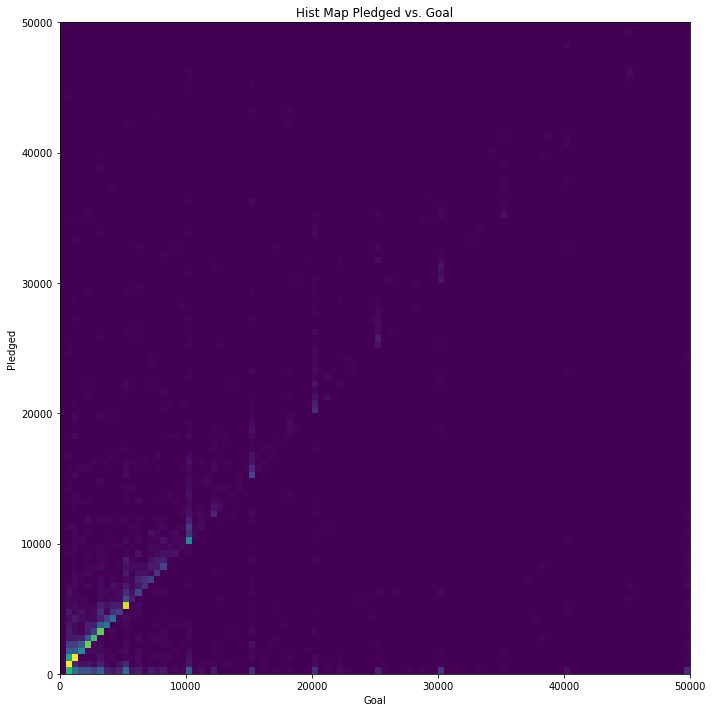

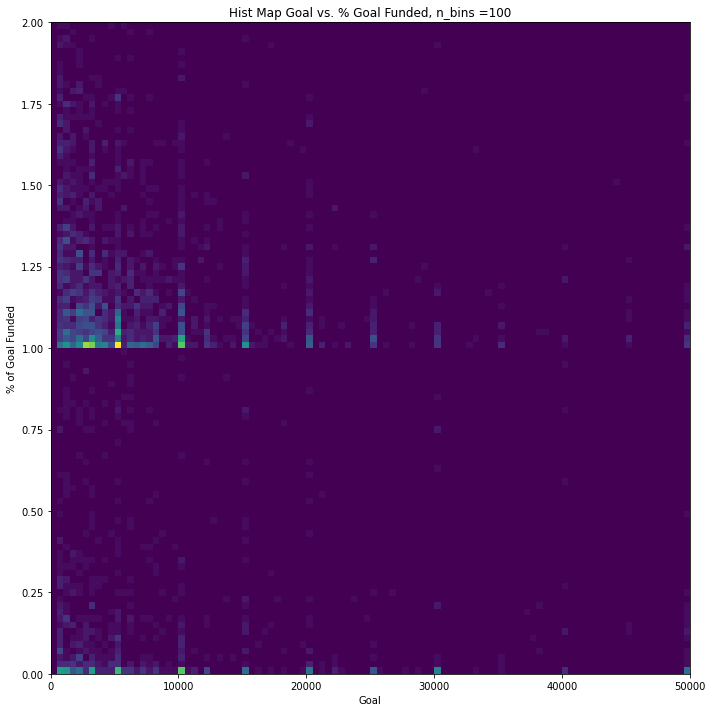

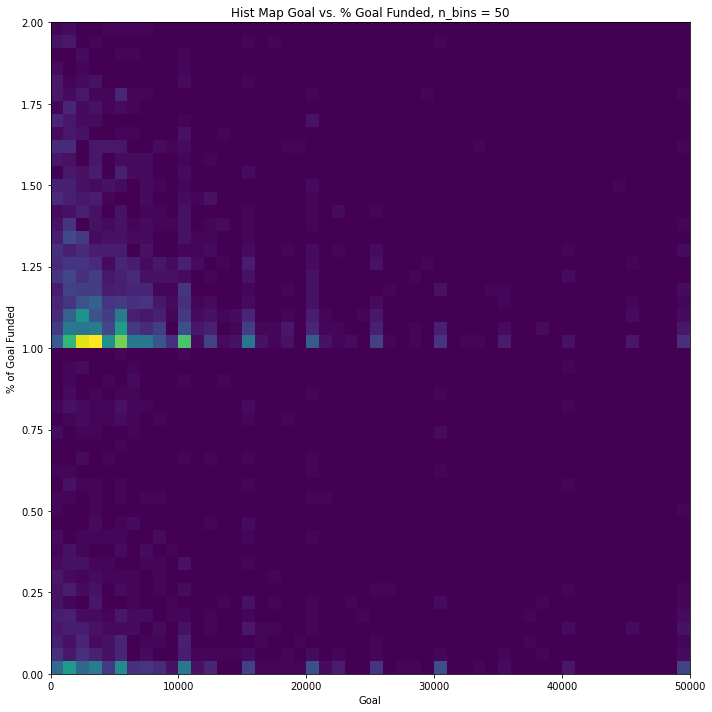

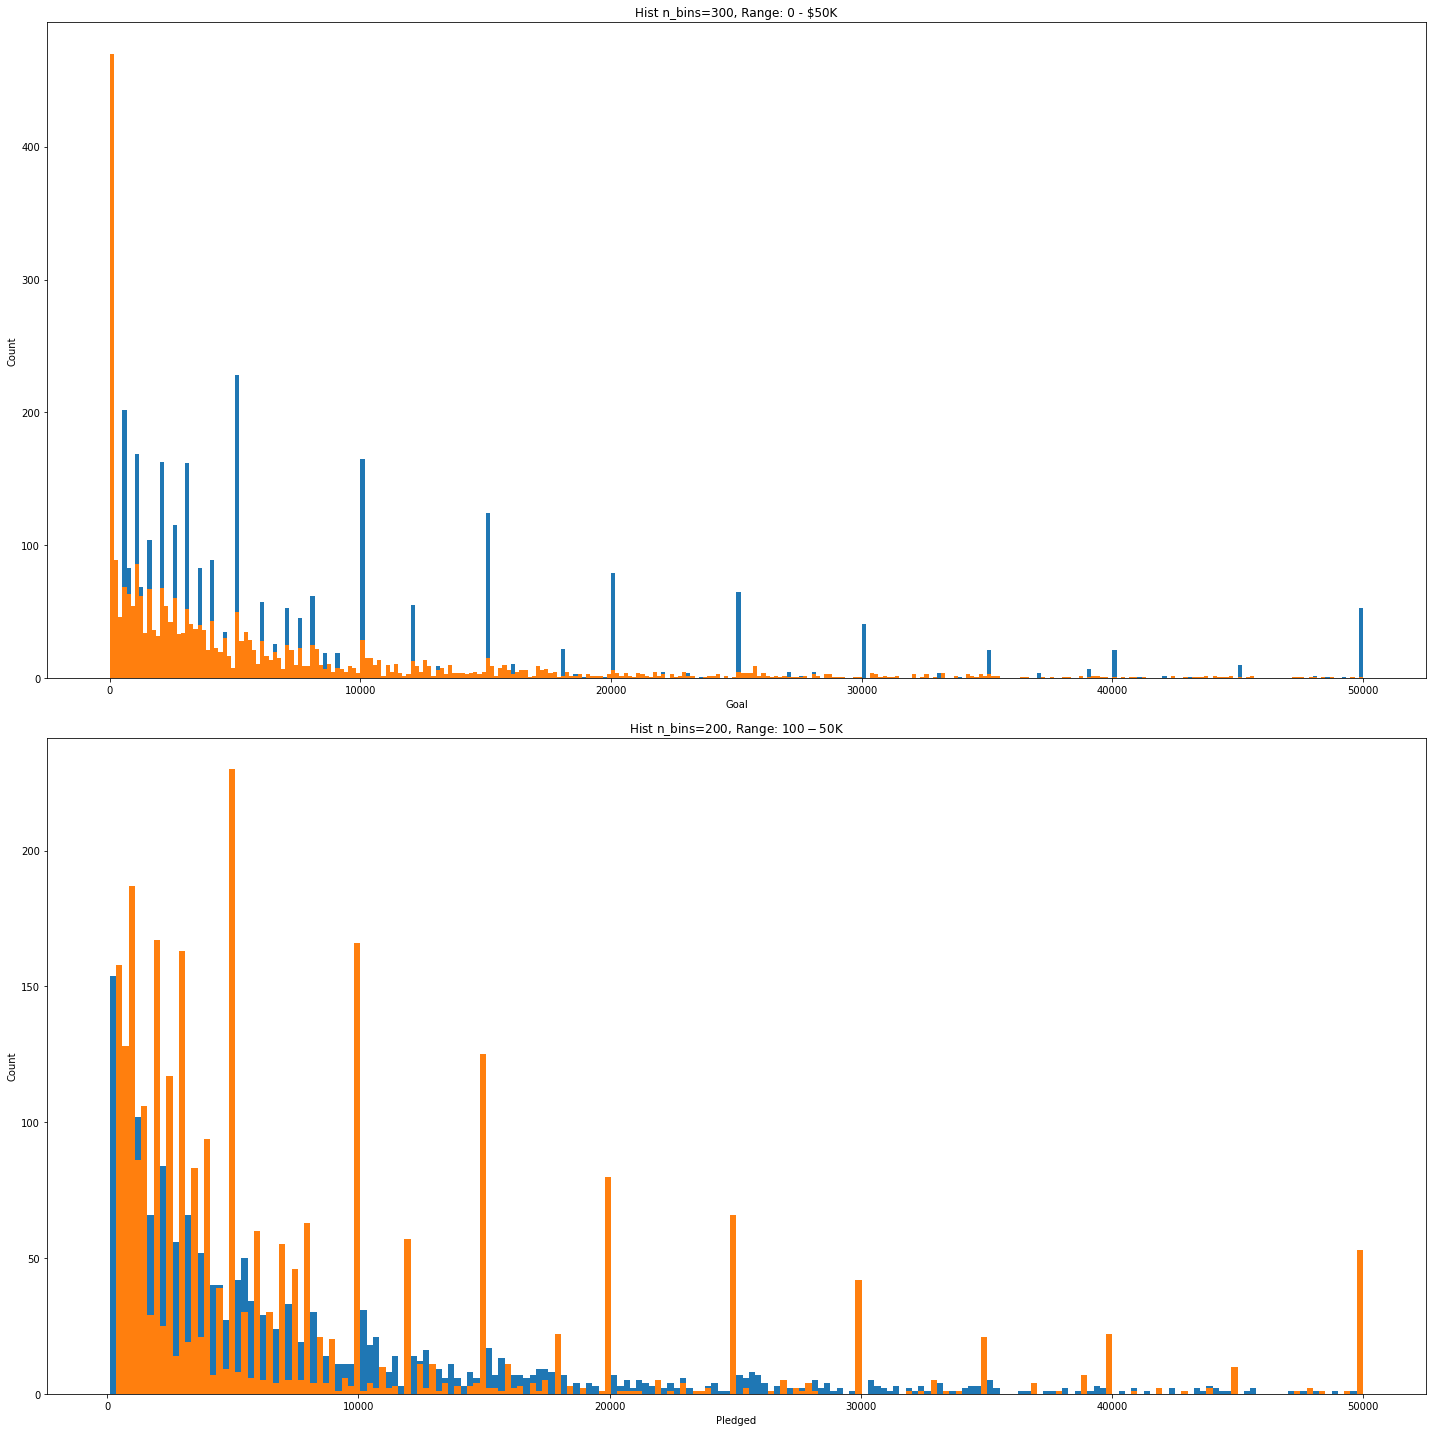

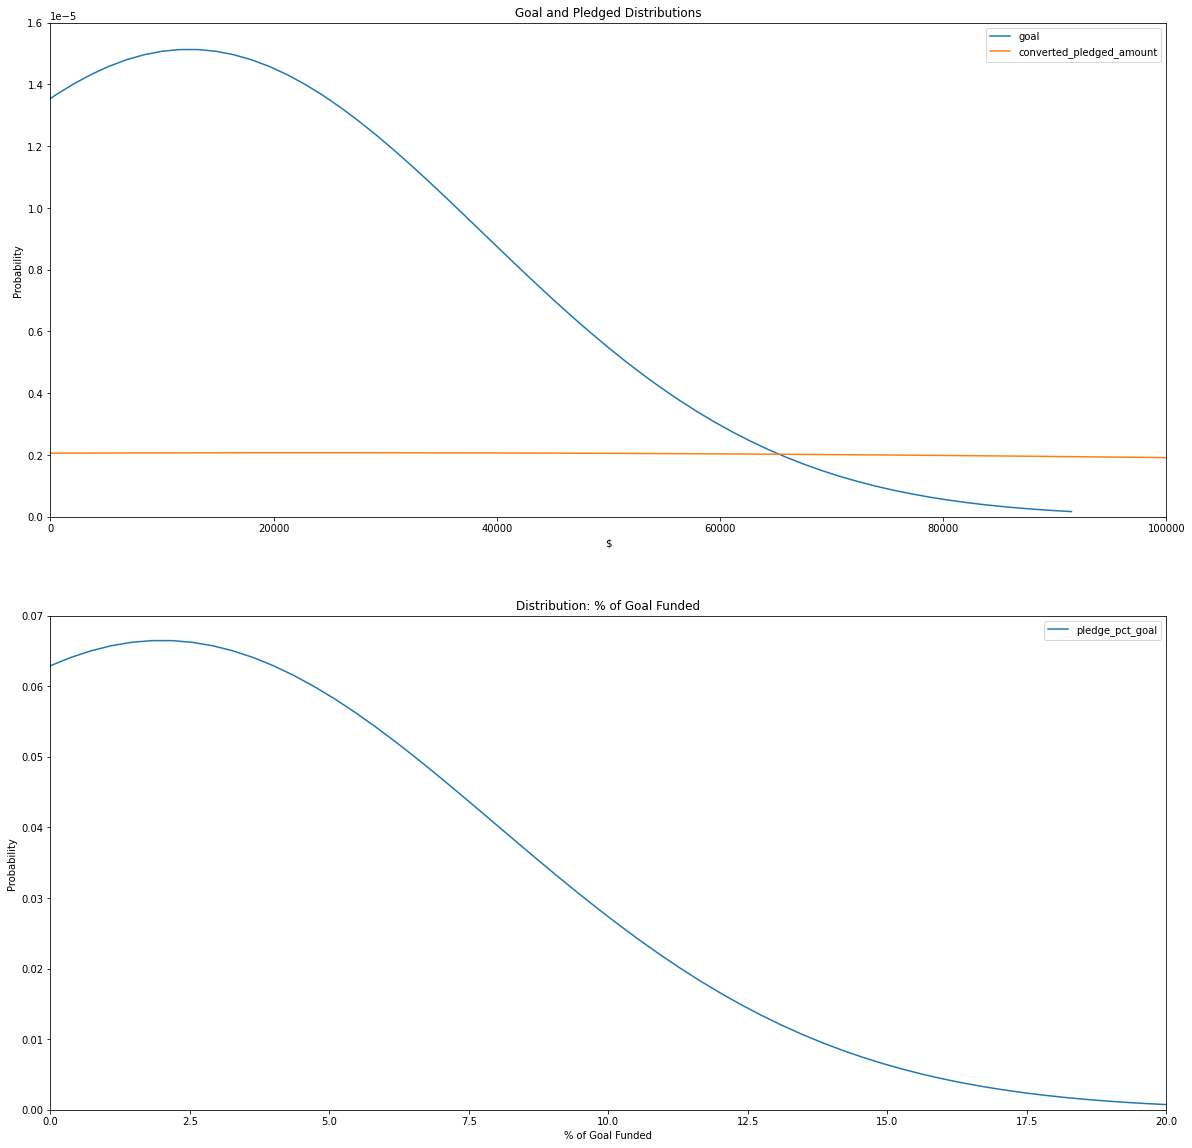

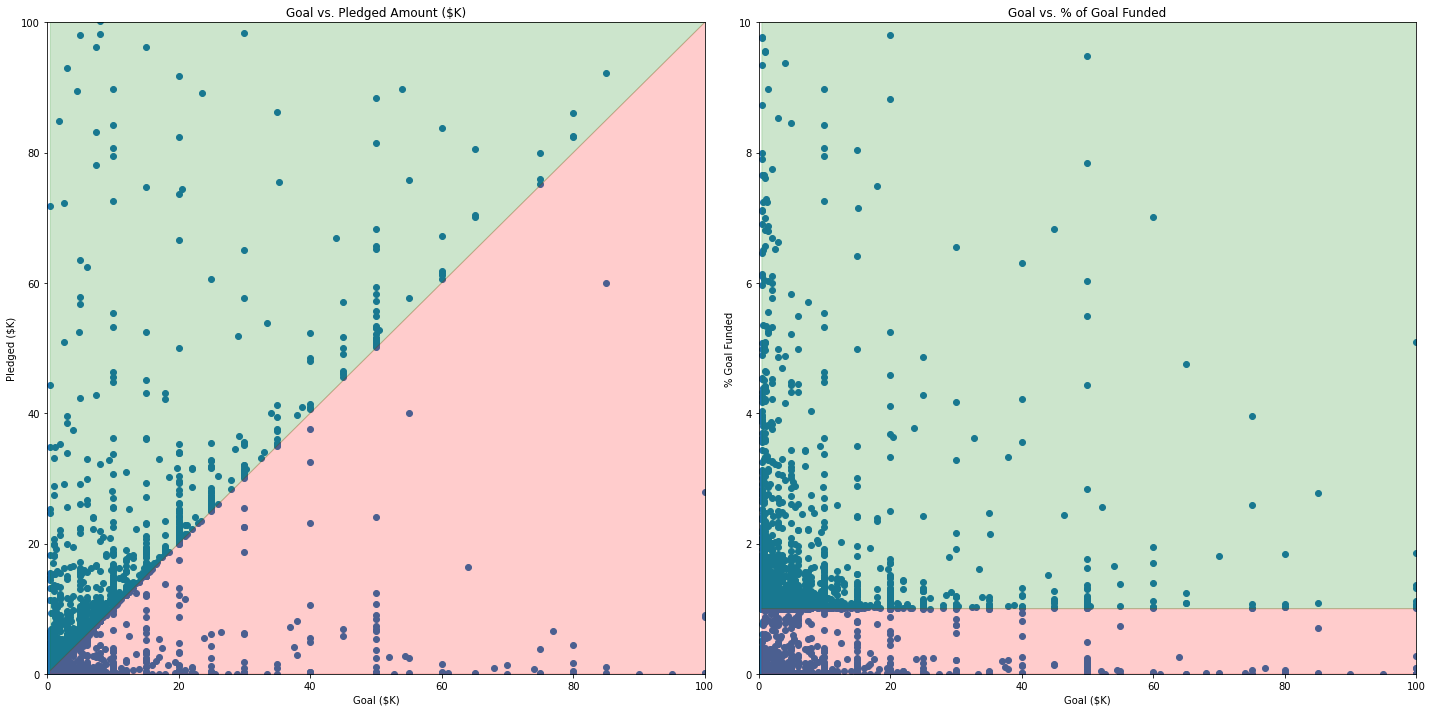

In [11]:
eda(df_train)

goal Mean = 12599.0 , 6 sigma range = 0 : 89507.0
converted_pledged_amount Mean = 19508.0 , 6 sigma range = 0 : 468383.0
pledge_pct_goal Mean = 2.0 , 6 sigma range = 0 : 20.0


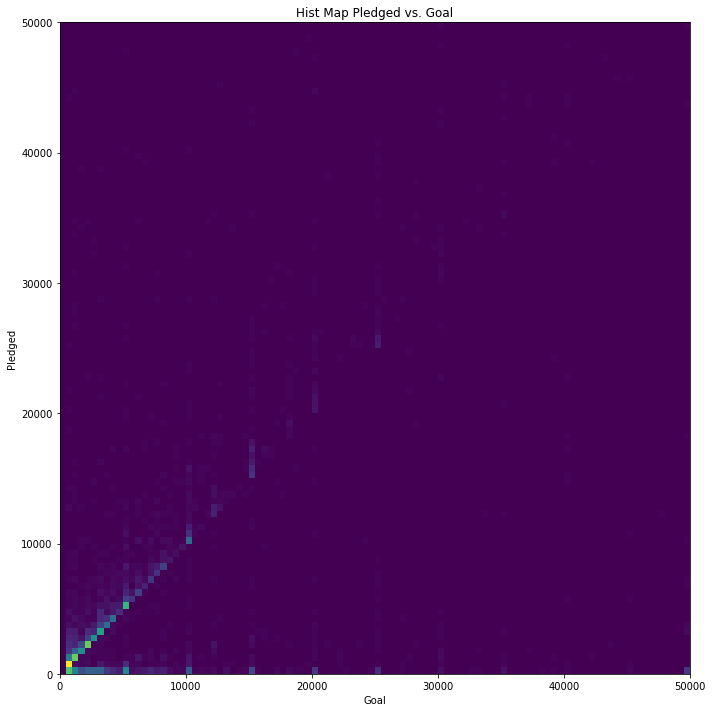

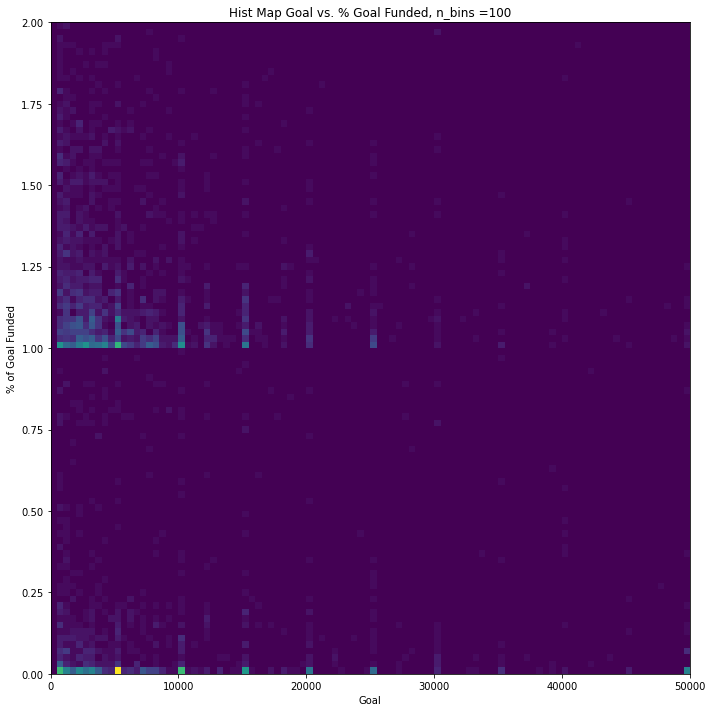

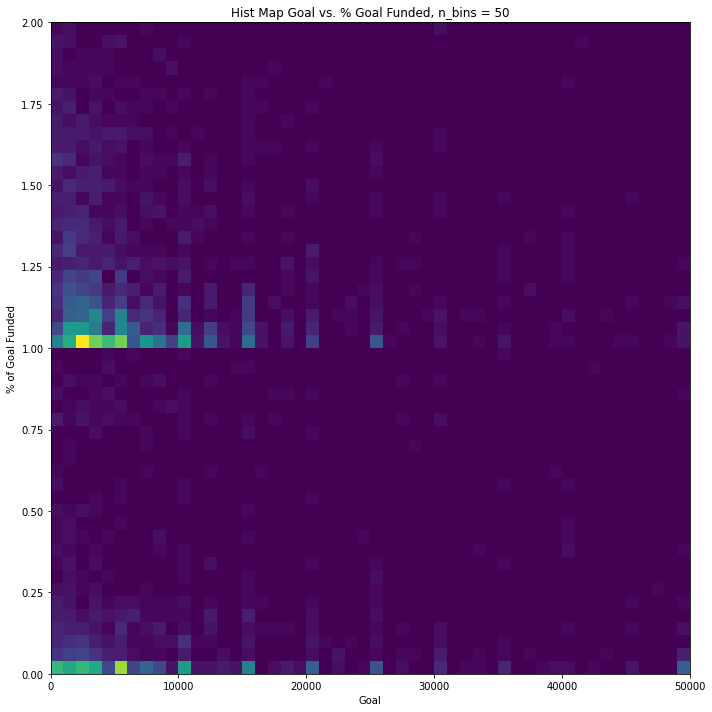

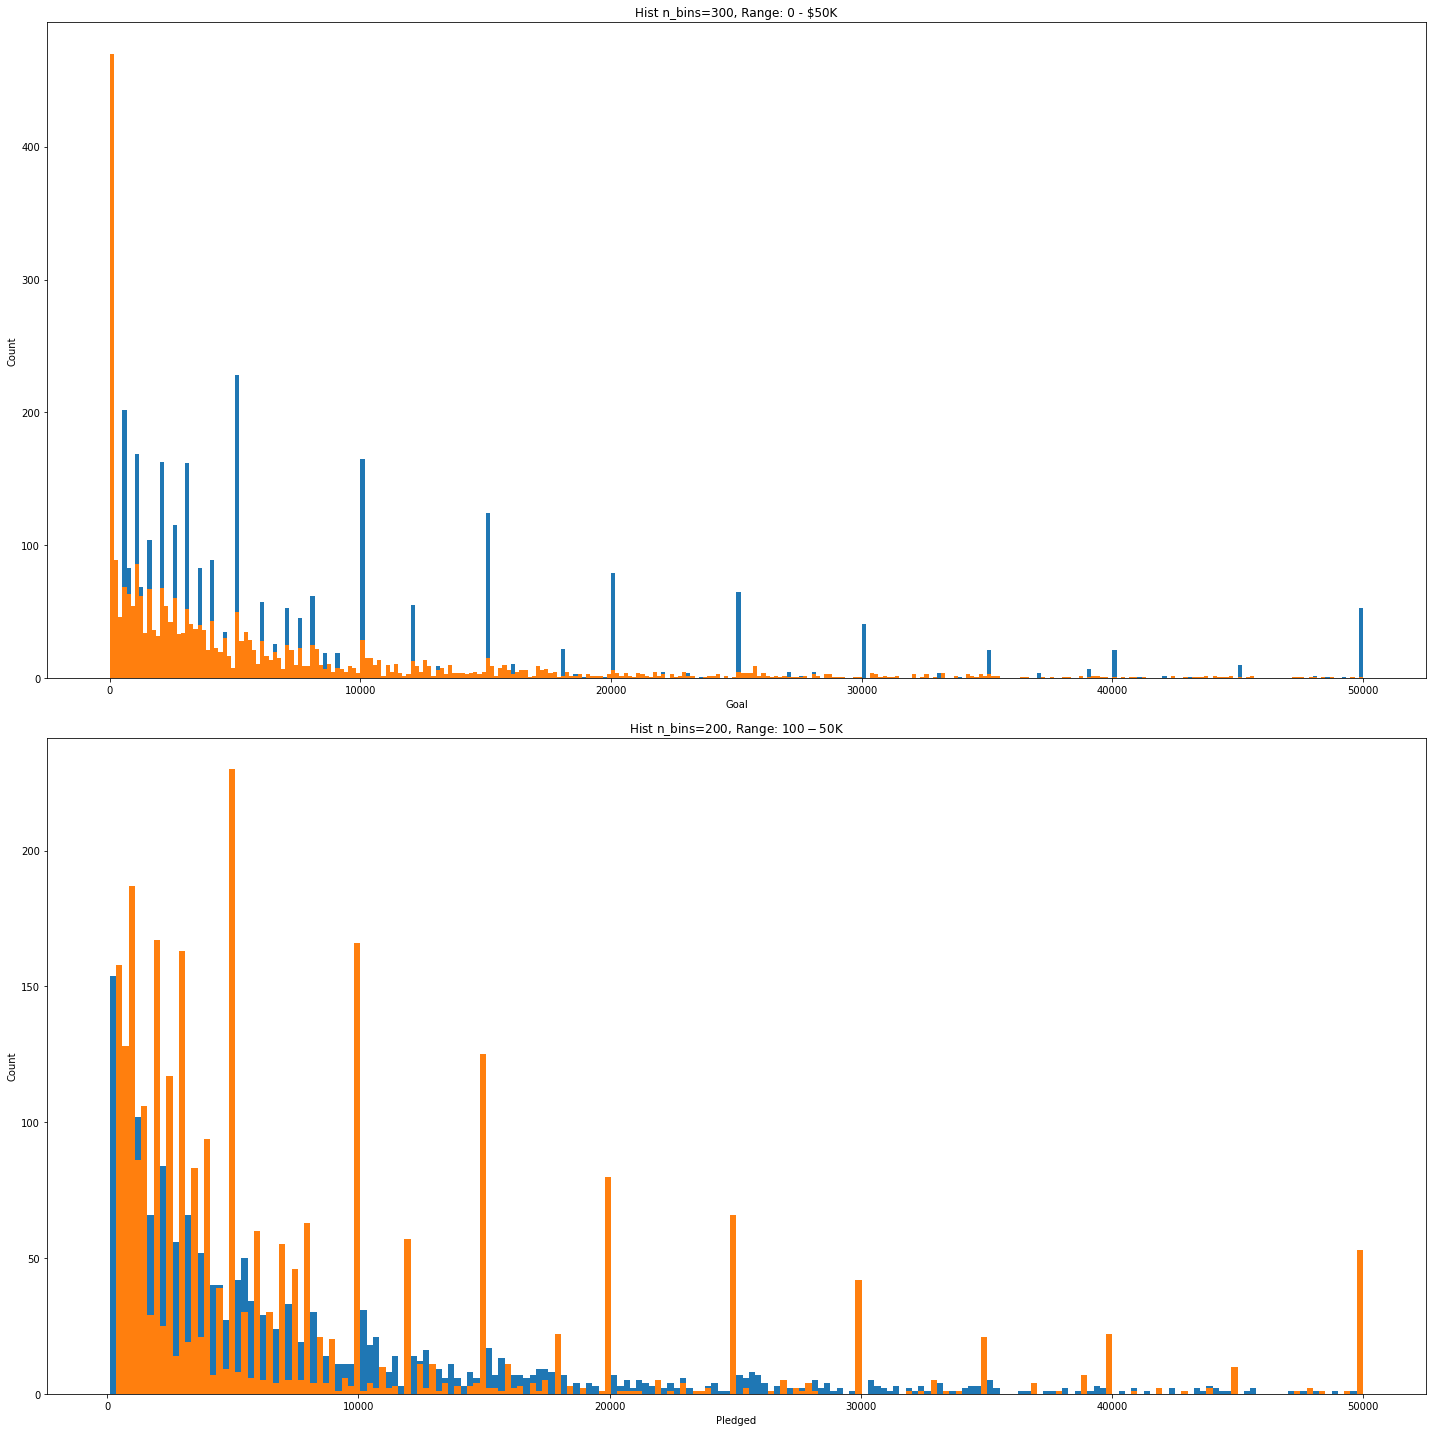

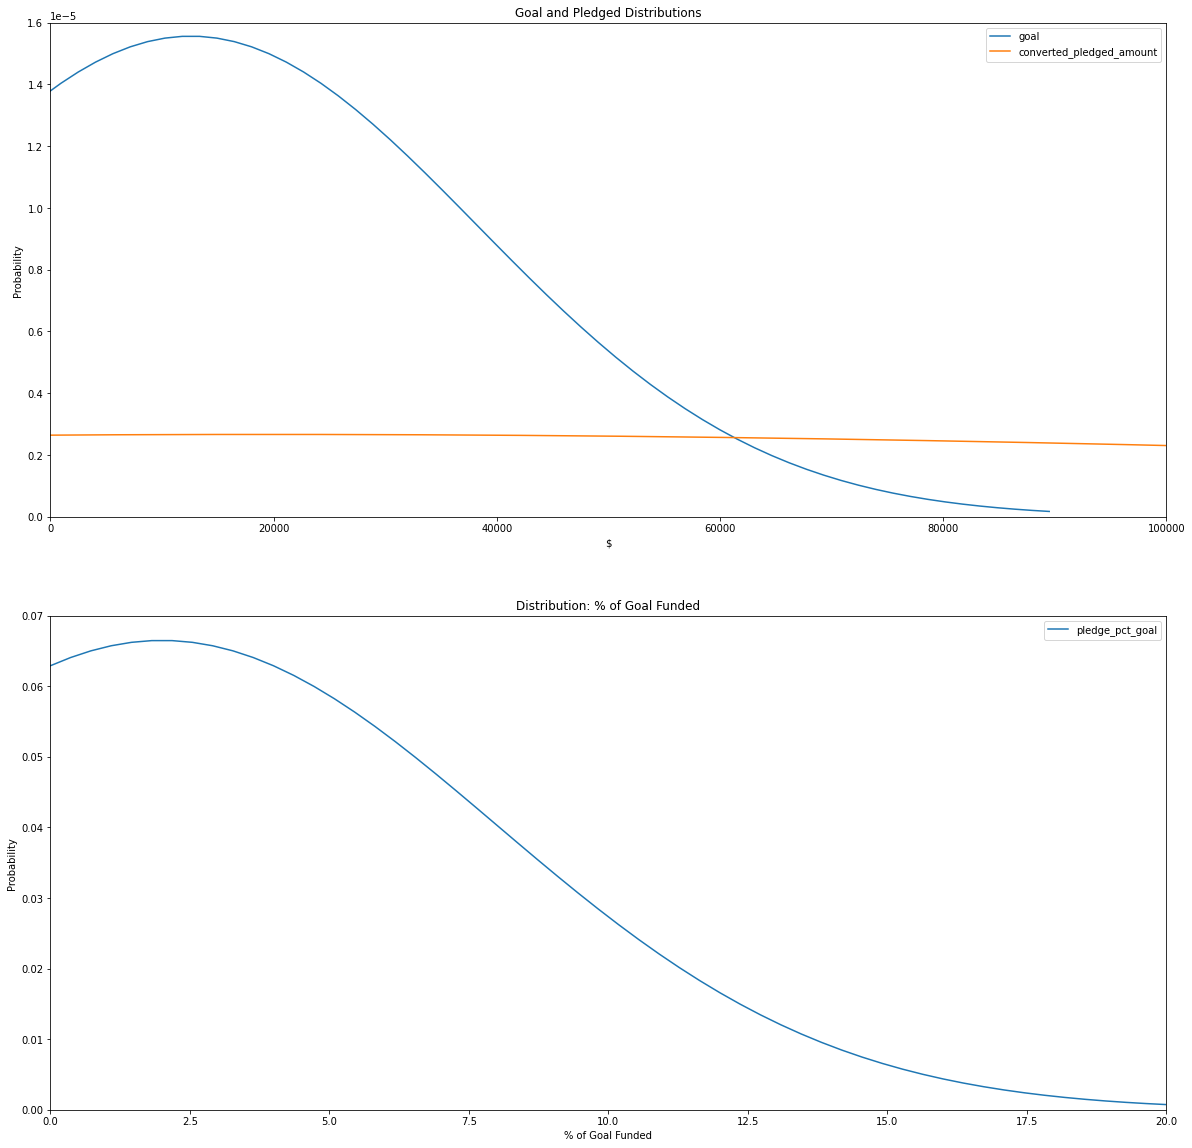

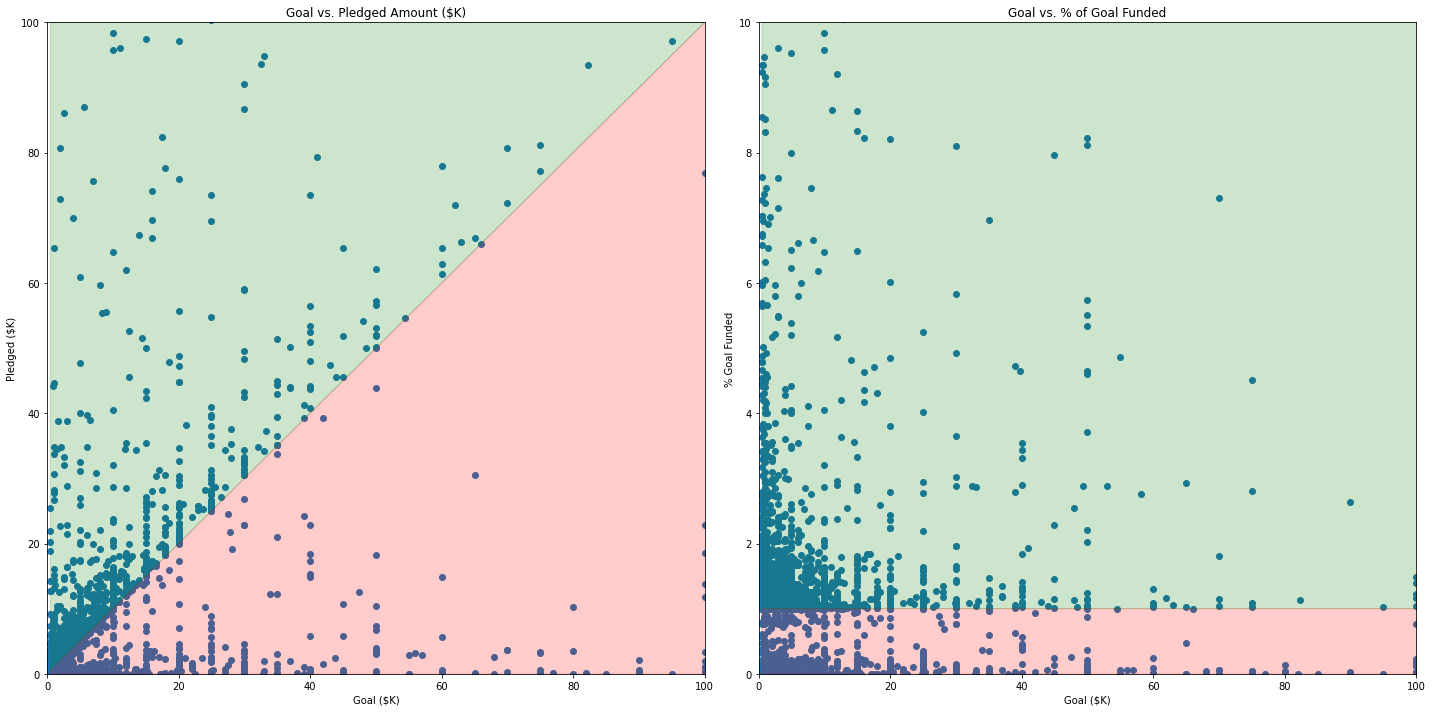

In [12]:
eda(df_test)

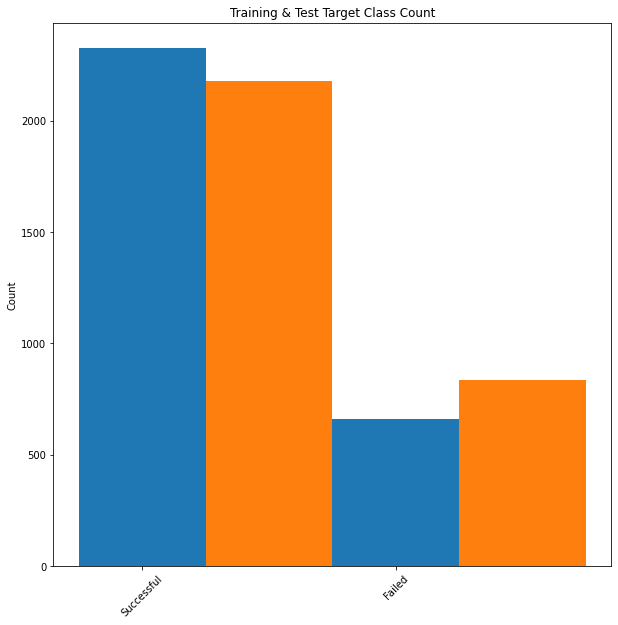

In [25]:
plot_train_test_target(df_train, df_test)